## 重みの初期値

### 重みの初期値を0にする？

過学習を抑え、汎化性能を高めるWeight decay(荷重減衰)という手法がある。
重みパラメータを小さくなるようにすると過学習が起きにくくなる。

これまでは `0.01 * np.random.randn(10, 100)` のように標準偏差が０．０１のガウス分布を用いた。

重みの初期値を０にする（重みを均一な値にする）のは悪いアイデアで、ランダムな初期値を使う必要がある。

### 隠れ層のアクティベーション分布

隠れ層のアクティベーションの分布を観察することで多くの知見が得られる。

> 活性化関数のあとの出力データをアクティベーションと呼ぶ

In [35]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)
    
# sd: 重みパラメータの初期値の標準偏差
# node_num: 各隠れ層のノード（ニューロン）の数
# activation: 活性化関数
def show_histgram(sd=1, node_num=100, activation=sigmoid):
    input_data = np.random.randn(1000, node_num)  # 1000個のデータ
    hidden_layer_size = 5  # 隠れ層が5層
    activations = {}  # ここにアクティベーションの結果を格納する
    x = input_data

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        # 初期値の値をいろいろ変えて実験しよう！
        w = np.random.randn(node_num, node_num) * sd

        a = np.dot(x, w)

        # 活性化関数の種類も変えて実験しよう！
        z = activation(a)

        activations[i] = z

    # ヒストグラムを描画
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
        plt.xlim(0.1, 1)
        plt.ylim(0, 7000)
        plt.hist(a.flatten(), 30, range=(0,1))
    plt.show()

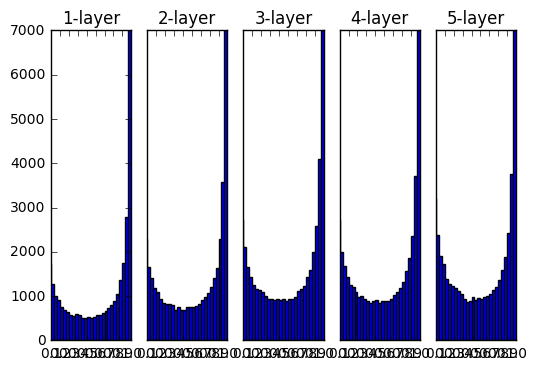

In [36]:
show_histgram(sd=1)

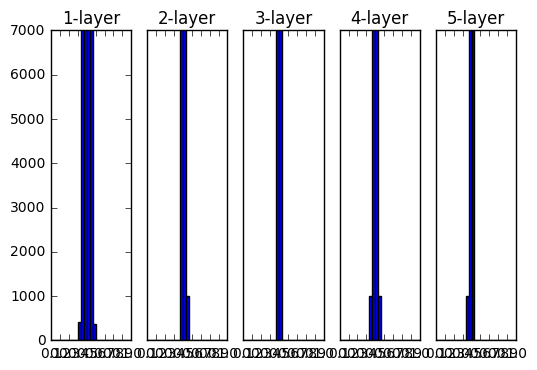

In [37]:
show_histgram(sd=0.01)

重みの初期値を標準偏差１のガウス分布に用いるとアクティベーションは０と１の周りに集中する。

シグモイド関数は０と１の周りで微分の値が０に近づくため、逆伝搬で勾配の値が小さくなり消えてしまう勾配消失（gradient vanishing)が起きる。

標準偏差を０．０１にすると、0.5付近に集中する。この場合微分の消失の問題はないが、アクティベーションに偏りにある事自体に問題がある。この場合多くのニューロンを用いても同様の値を持ち、ニューロンを増やす意味がなくなるため。

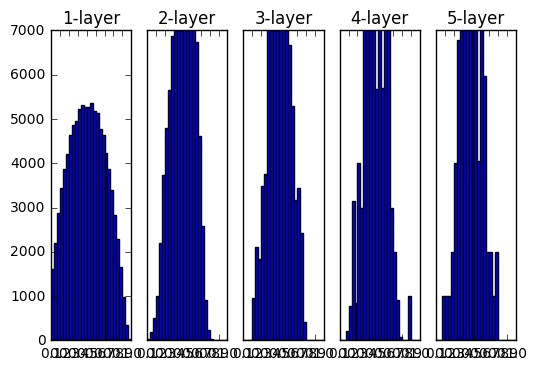

In [38]:
show_histgram(sd=np.sqrt(1.0 / 100.0),node_num=100)

前層のノード数をnとしたとき、$1/\sqrt{n}$の標準偏差を持つXavierの初期値がディープラーニングのフレームワークで標準的に用いられている。これを用いたとき、上位の層に行くに連れいびつにはなるが広がりを持った分布になっていることがわかる。

> sigmoid関数の代わりにtanh関数を用いるといびつさが改善される。sigmoidは(0, 0,5)で対象になるがtanhは(0, 0)で対称になる。活性化関数に用いる関数は原点対称であることが望ましいと知られている。

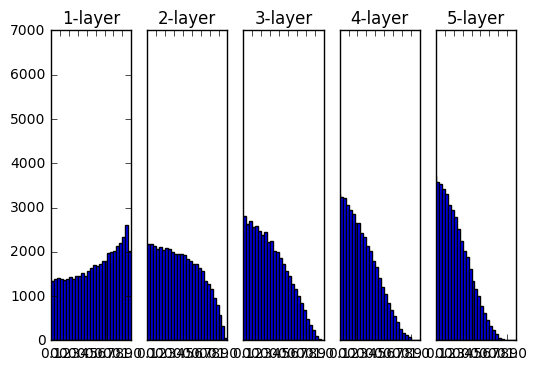

In [39]:
show_histgram(sd=np.sqrt(1.0 / 100.0),node_num=100,activation=tanh)
# うまく行ってない？

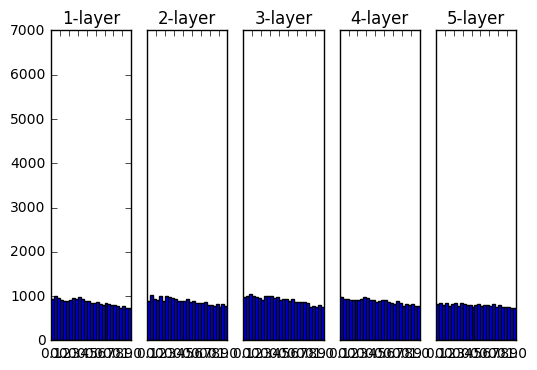

In [41]:
# 活性化関数がReLUの場合はHeの初期値
show_histgram(sd=np.sqrt(2.0 / 100.0),node_num=100,activation=ReLU)

### MNISTデータセットによる重み初期値の比較

===========iteration:0===========
std=0.01:2.30255766097
He:2.37828210092
Xavier:2.30161171691
===========iteration:100===========
std=0.01:2.30159306086
He:1.53146559177
Xavier:2.23856388764
===========iteration:200===========
std=0.01:2.30114385747
He:0.752878273832
Xavier:2.06418295219
===========iteration:300===========
std=0.01:2.30290204817
He:0.568935969865
Xavier:1.73713076069
===========iteration:400===========
std=0.01:2.3014989137
He:0.478401159111
Xavier:1.13063355535
===========iteration:500===========
std=0.01:2.30255254865
He:0.378675117142
Xavier:0.764625707388
===========iteration:600===========
std=0.01:2.30099338194
He:0.433243745307
Xavier:0.712556864092
===========iteration:700===========
std=0.01:2.30451834207
He:0.337477079212
Xavier:0.470329655093
===========iteration:800===========
std=0.01:2.30118840813
He:0.249771003588
Xavier:0.397367701841
===========iteration:900===========
std=0.01:2.30135151302
He:0.37869093257
Xavier:0.482814849149
===========iteration:

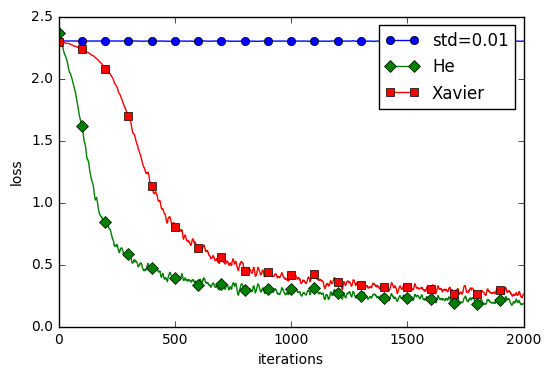

In [42]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()